# Code for: reporting noise, imported cases, and modelling elimination

In [1]:
using Plots, Measures

include("../src/LoadData.jl")
include("../src/PMMH.jl")
include("../src/MarginalPosterior.jl")
include("../src/Support.jl")

# Load data
Y = loadData("NZCOVID");

In [2]:
function noiseImportsElimModel(θ, Y::DataFrame, opts::Dict; showProgress=false)
    
    # Extract frequently used options
    T = opts["T"]
    N = opts["N"]
    L = opts["L"]
    h = opts["elimHorizon"]
    
    # Initialise output matrices
    R = zeros(N, T) # Reproduction number
    I = zeros(N, T) # Local infections
    C = zeros(N, T) # Reported cases (if enabled)
    elim = zeros(N, T) # Elimination indicator (if enabled)
    W = zeros(N, T) # Model weights
    
    # Sample from initial distributions
    R[:,1] = rand.(opts["pR0"], N)
    I[:,1] = rand.(opts["pI0"], N)
    
    # Run the filter
    for tt = 2:T
        
        # Project according to the state-space model
        R[:,tt] = exp.(rand.(Normal.(log.(R[:,tt-1]), θ[1])))
        
        # Calculate force-of-infection and sample infections
        combined_infections = (I[:,tt-1:-1:1] .+ Y.border[tt-1:-1:1]')
        Λ = sum(combined_infections  .* opts["ω"][1:tt-1]', dims=2)
        I[:,tt] = rand.(Poisson.(R[:,tt] .* Λ))
        
        # Weight according to the observation model
        r = 1/θ[2]
        p = 1 ./ (1 .+ θ[2] * I[:,tt])
        W[:,tt] = pdf.(NegativeBinomial.(r, p), Y.local[tt])
        
        # Resample
        inds = wsample(1:N, W[:,tt], N; replace=true)
        R[:, max(tt - L, 1):tt] = R[inds, max(tt - L, 1):tt]
        I[:, max(tt - L, 1):tt] = I[inds, max(tt - L, 1):tt]
        
        # Calculate elimination probability (if enabled)
        if opts["calculateElimProb"]
            
            Rproj = zeros(N, tt + h)
            Iproj = zeros(N, tt + h)
            
            Rproj[:,1:tt] = R[:,1:tt]
            Iproj[:,1:tt] = I[:,1:tt]
            
            imported_cases = zeros(tt+h)
            imported_cases[1:tt] = Y.border[1:tt]
            
            for ss = (tt+1):(tt+h)
                Rproj[:,ss] = exp.(rand.(Normal.(log.(Rproj[:,ss-1]), θ[1])))
                combined_infections = (Iproj[:,ss-1:-1:1] .+ imported_cases[ss-1:-1:1]')
                Λ = sum(combined_infections  .* opts["ω"][1:ss-1]', dims=2)
                Iproj[:,ss] = rand.(Truncated.(Poisson.(Rproj[:,ss] .* Λ), 0, 1e5))
            end
            
            elim[:,tt] = sum(Iproj[:,tt+1:end], dims=2) .== 0 # No future cases
            
        end
        
    end

    # Calculate predictive cases if enabled
    if opts["predictiveValues"]
        for tt = 1:T
            r = 1/θ[2]
            p = min.(1 ./ (1 .+ θ[2] * I[:,tt]), 1-eps())
            C[:,tt] = rand.(NegativeBinomial.(r, p))
        end
    end
    
    # Store output as three-dimensional array
    X = zeros(N, T, 4)
    X[:,:,1] = R
    X[:,:,2] = I
    X[:,:,3] = C
    X[:,:,4] = elim
    
    return(X, W)
    
end


noiseImportsElimModel (generic function with 1 method)

In [3]:
opts = Dict(

    # Bootstrap filter options
    "T" => size(Y, 1), # Number of time-steps
    "N" => 1000, # Number of particles
    "L" => 50, # Fixed-lag resampling length
    "ω" => pdf.(Gamma(2.36, 2.74), 1:128), # Serial interval
    "pR0" => Uniform(0, 10), # Prior on Rt at t = 0
    "pI0" => Dirac(1), # Prior on I at t = 0
    "predictiveValues" => false, # Whether to calculate predictive cases
    "calculateElimProb" => false, # Whether to calculate elimination probability
    "elimHorizon" => 28, # Horizon for elimination probability calculation

    # PMMH options
    "nChains" => 3, # Number of chains
    "chunkSize" => 100, # Number of iterations
    "maxChunks" => 50, # Maximum number of chunks
    "maxRhat" => 1.05,  # Stopping criterion: maximum Rhat value
    "minESS" => 100, # Stopping criterion: minimum effective sample size (we increase this to produce nice parameter posterior plots)
    "showChunkProgress" => true, # Whether to show progress of each chunk
    "propStdDevInit" => sqrt.([0.1, 0.01]), # Initial proposal standard deviation (this is adaptively fit)
    "paramPriors" => [Uniform(0, 1), Uniform(0, 1)],
    "initialParamSamplers" => [Uniform(0.1, 0.3), Uniform(0.01, 0.03)],
    "paramLimits" => [(0, 1), (0, 1)],
    "paramNames" => ["σ", "ϕ"],

    # Marginal posterior options
    "posteriorNumberOfParticles" => 1000,
    "posteriorParamSamples" => 100

);

In [ ]:
# Generate some quick samples for the marginal posterior
(θ, diag) = PMMH(noiseImportsElimModel, Y, opts; verbose=false)
Chains(θ, opts["paramNames"])

Chains MCMC chain (600×2×3 Array{Float64, 3}):

Iterations        = 1:1:600
Number of chains  = 3
Samples per chain = 600
parameters        = σ, ϕ

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           σ    0.1627    0.0477     0.0011    0.0039   139.9073    1.0113
           ϕ    0.0202    0.0198     0.0005    0.0015   116.6895    1.0331

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0843    0.1312    0.1569    0.1857    0.2841
           ϕ    0.0007    0.0047    0.0142    0.0296    0.0775


In [5]:
opts["predictiveValues"] = true
opts["calculateElimProb"] = true
X = marginalPosterior(noiseImportsElimModel, θ, Y, opts)
(mR, medR, lR, uR) = processResults(X[:,:,1])
(mI, medI, lI, uI) = processResults(X[:,:,2])
(mC, medC, lC, uC) = processResults(X[:,:,3])
pElim = mean(X[:,:,4], dims=1)[1:end];

In [6]:
# Run additional PMMH samples to plot parameter posterior
opts["predictiveValues"] = false
opts["calculateElimProb"] = false
opts["minESS"] = 1000
(θ, diag) = PMMH(noiseImportsElimModel, Y, opts; verbose=false)
Chains(θ, opts["paramNames"])

Chains MCMC chain (4600×2×3 Array{Float64, 3}):

Iterations        = 1:1:4600
Number of chains  = 3
Samples per chain = 4600
parameters        = σ, ϕ

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           σ    0.1558    0.0428     0.0004    0.0013   1149.5905    1.0030
           ϕ    0.0179    0.0172     0.0001    0.0006    737.8028    1.0007

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0891    0.1247    0.1501    0.1805    0.2527
           ϕ    0.0005    0.0052    0.0131    0.0252    0.0647


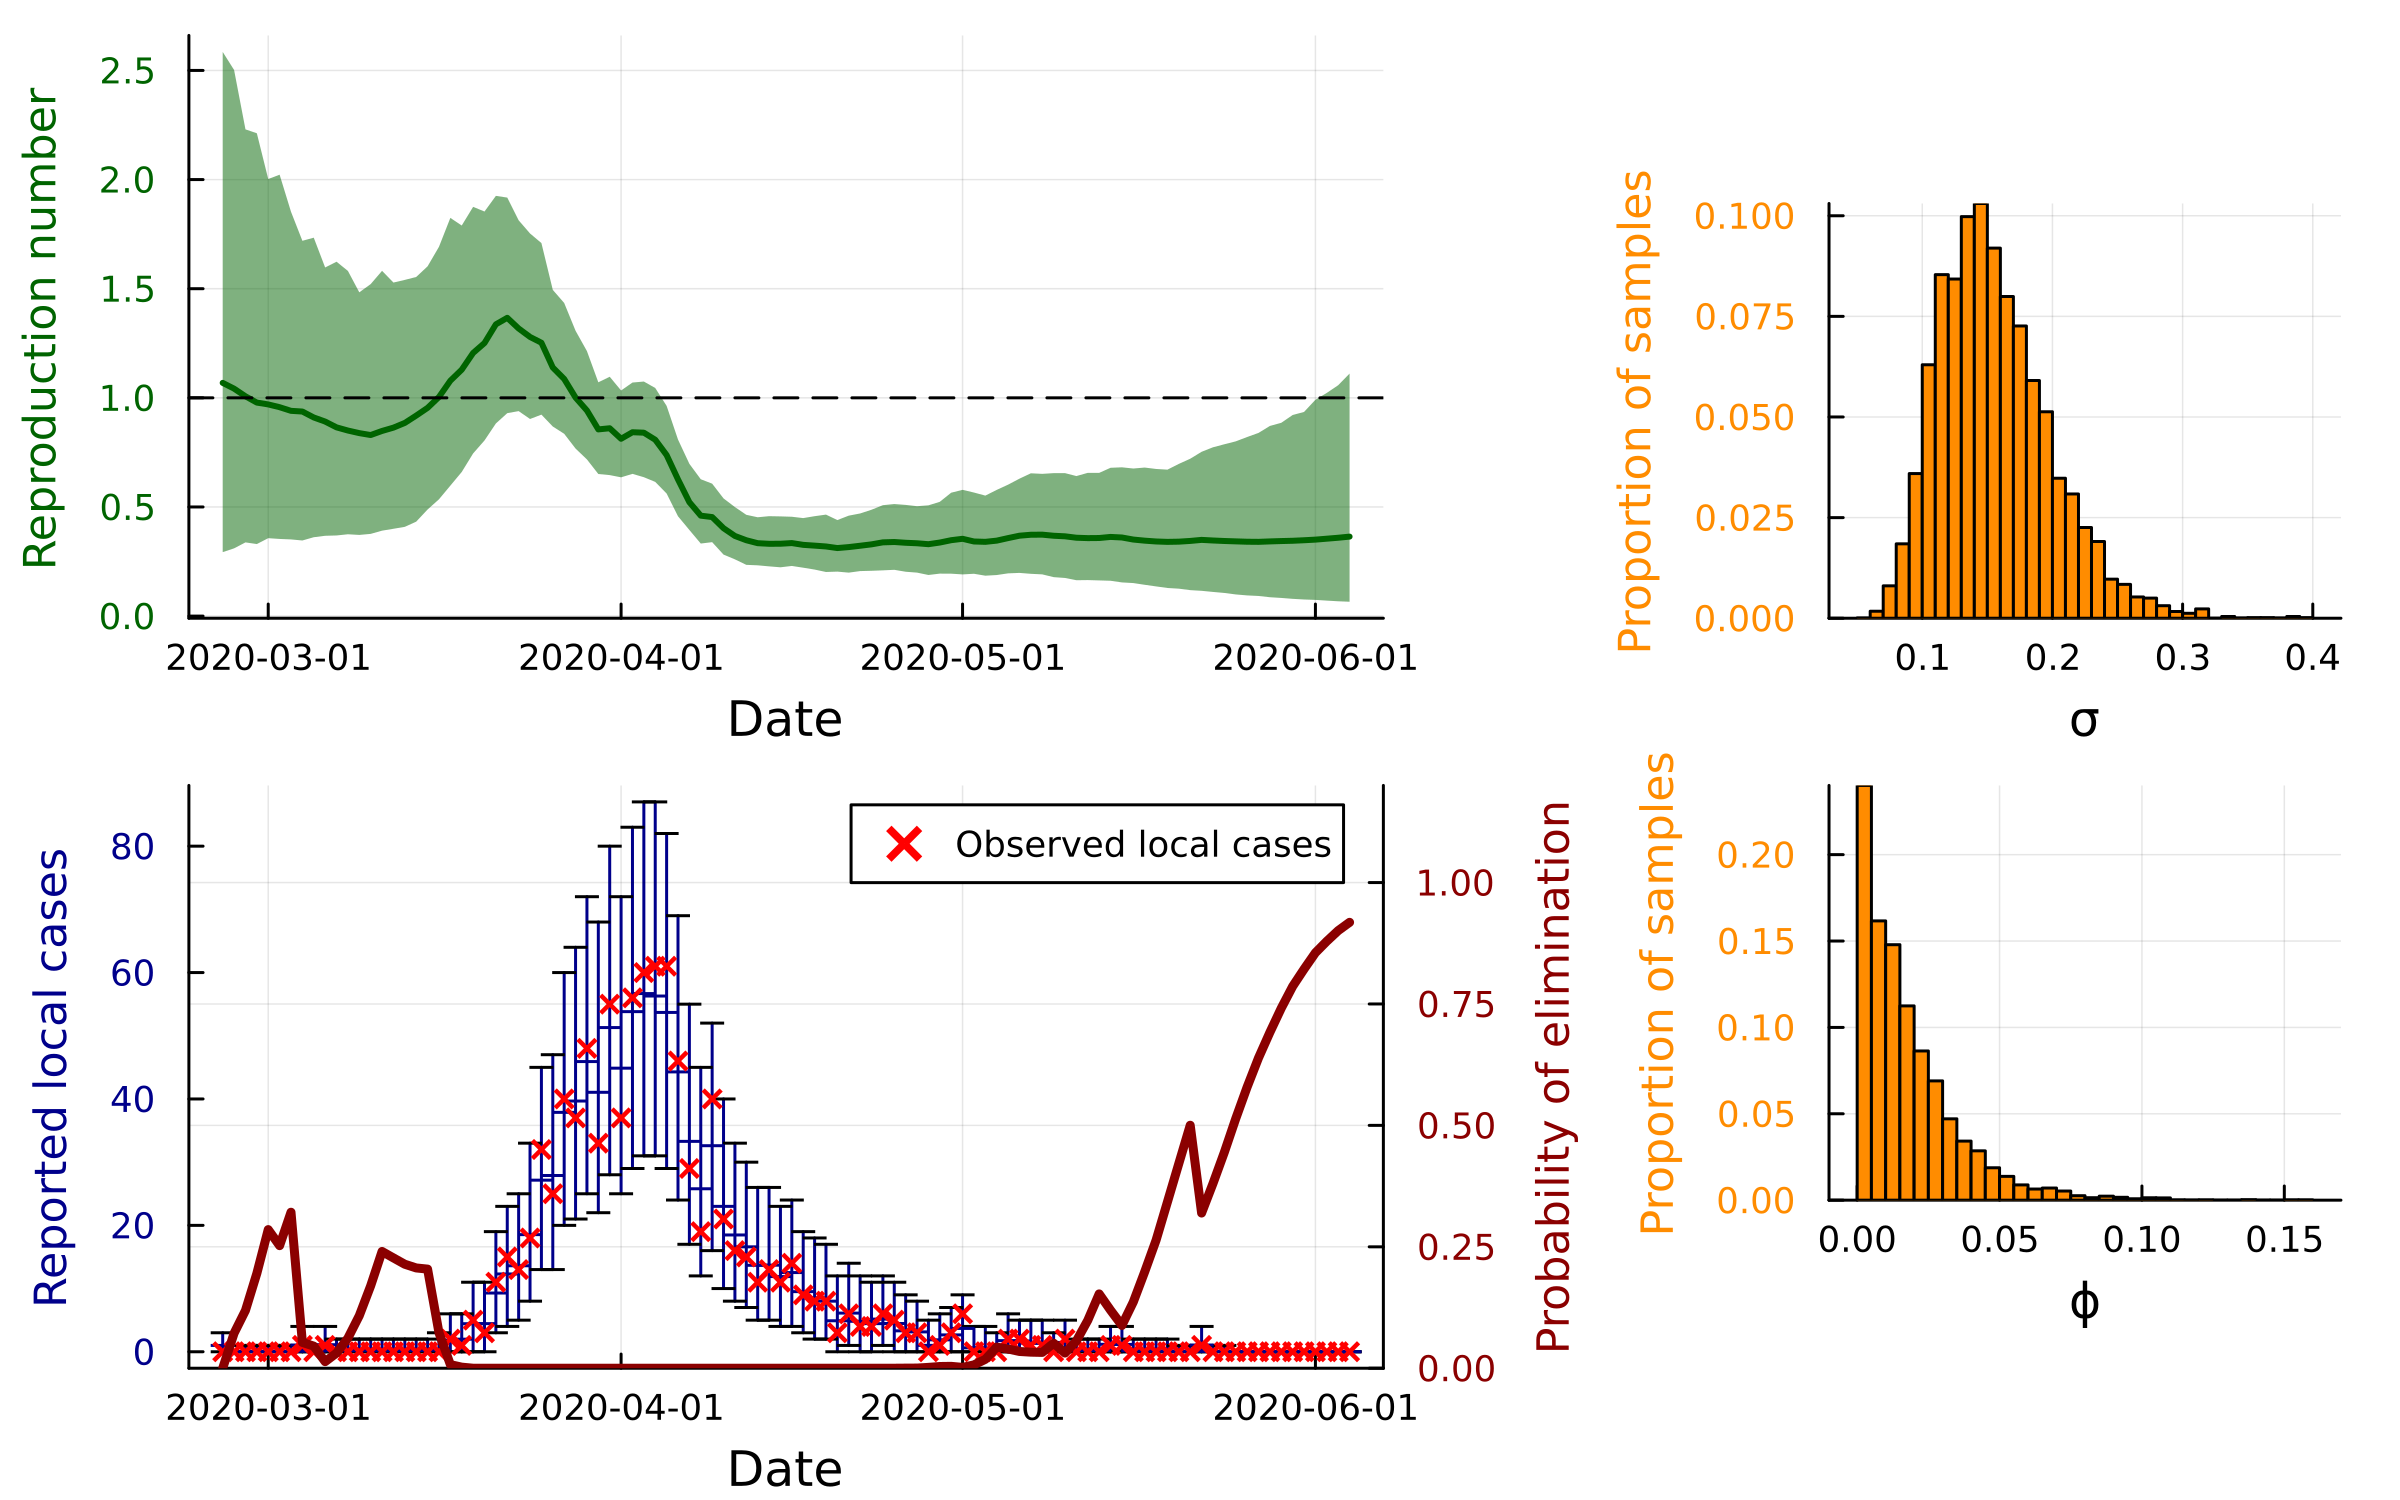

P(elimination) at time T: 91.81%


In [7]:
# Plot output
pltR = plot(xlabel="Date", ylabel="Reproduction number", yguidefont=font(10, :darkgreen), ytickfont=font(8, :darkgreen))
pltR = plot!(Y.date, mR, ribbon=(mR-lR, uR-mR), color=:darkgreen, label=false, linewidth=2)
pltR = hline!([1], label=false, color=:black, line=:dash)

pltC = plot(xlabel="Date", ylabel="Reported local cases")
pltC = scatter!(Y.date, mC, errorbar=(mC-lC, uC-mC), color=:darkblue, lc=:darkblue, markershape=:hline, label=false)
pltC = scatter!(Y.date, Y.local, color=:red, label="Observed local cases", markershape=:x, markersize=3, markerstrokewidth=1.5)
pltC = plot!(yguidefont=font(10, :darkblue), ytickfont=font(8, :darkblue), ygrid=true, xgrid=true)

pltElim = plot!(twinx(), Y.date, pElim, ylabel="Probability of elimination",
    color=:darkred, label=false, linewidth=3, ylims=(0, 1.2),
    yguidefont=font(10, :darkred), ytickfont=font(8, :darkred), ygrid=true, xgrid=true)

θl = resizeParams(θ)
pltSigma = histogram(θl[:,1], bins=50, xlabel="σ", ylabel="Proportion of samples", color=:darkorange, legend=false, normalize=:probability)
pltSigma = plot!(pltSigma, yguidefont=font(10, :darkorange), ytickfont=font(8, :darkorange), ygrid=true, xgrid=true)
pltPhi = histogram(θl[:,2], bins=50, xlabel="ϕ", ylabel="Proportion of samples", color=:darkorange, legend=false, normalize=:probability)
pltPhi = plot!(pltPhi, yguidefont=font(10, :darkorange), ytickfont=font(8, :darkorange), ygrid=true, xgrid=true)

plt_ts = plot(pltR, pltElim, layout=(2,1), size=(800,500), left_margin=3mm, right_margin=3mm, dpi=300)
l_params = @layout [grid(4, 1, heights=[0.05, 0.45, 0.45, 0.05])]
plt_params = plot(plot(framestyle=:none), pltSigma, pltPhi, plot(framestyle=:none), layout=l_params, size=(500,500), left_margin=3mm, right_margin=3mm, dpi=300)

l = @layout [grid(1,2, widths=[0.7, 0.3])]
plt_both = plot(plt_ts, plt_params, layout=l, size=(800,500), left_margin=3mm, right_margin=3mm, dpi=300)
png("figures/noiseimportselim.png")
display(plt_both)

println("P(elimination) at time T: $(round(100*pElim[end], digits=2))%")

In [8]:
# Model coverage
coverage = mean((lC[2:end] .<= Y.local[2:end]) .& (uC[2:end] .>= Y.local[2:end]))
nonzeroinds = findall(Y.local .> 0)[2:end]
coverageNonZero = mean((lC[nonzeroinds] .<= Y.local[nonzeroinds]) .& (uC[nonzeroinds] .>= Y.local[nonzeroinds]))

println("Coverage: ", coverage)
println("Non-zero coverage: ", coverageNonZero)

Coverage: 1.0
Non-zero coverage: 1.0


In [9]:
# Run model until time 40 and use L = 30 (so we sample from the full marginal posterior for days 10 to 40)
opts2 = deepcopy(opts)
opts2["T"] = 40
opts2["L"] = 30
opts2["calculateElimProb"] = false
Y2 = Y[1:opts2["T"],:]
X2 = marginalPosterior(noiseImportsElimModel, θ, Y2, opts2)
    
# Find samples of max values of Rt
traj_inds = 10:40
maxvals = maximum(X2[:,traj_inds,1], dims=2)[1:end]
(mean_max, lower_max, upper_max) = (mean(maxvals), quantile(maxvals, 0.025), quantile(maxvals, 0.975))
    
# Find the timing of max values of Rt
maxInds = [findfirst(X2[ii,traj_inds,1] .== maxvals[ii]) for ii in 1:size(X2,1)]
maxDates = Y2.date[traj_inds][maxInds]
inds = Int.([median(maxInds), quantile(maxInds, 0.025), quantile(maxInds, 0.975)])
(med_date, lower_date, upper_date) = Y2.date[traj_inds][inds]


println("Peak Rt = $(round(mean_max, digits=2)) (95% CI: $(round(lower_max, digits=2)), $(round(upper_max, digits=2)))")
println("Peak Rt date = $(med_date) (95% CI: $(lower_date), $(upper_date))")


Peak Rt = 1.59 (95% CI: 1.18, 2.24)
Peak Rt date = 2020-03-22 (95% CI: 2020-03-06, 2020-03-27)
